# 定义深度神经网络,激活函数selu
## selu自带归一化功能的激活函数，缓解梯度消失，效果很好

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:

fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
#x = (x - u) / std

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaler = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaler = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)


In [4]:
#tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):#定义20层的深度神经网络
    model.add(keras.layers.Dense(100,activation='selu'))

model.add(keras.layers.Dense(10))

# sparse的原因：将y的分类转换为one_hot编码
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = 'sgd',
             metrics = ['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
#在fit里添加callback:TensorBoard,EarlyStopping,ModelCheckpoint
#查看TensorBoard命令：
#tensorboard --lodger=callbacks然后用浏览器访问
# 例子：
# (mytf) mac:data mac$ tensorboard --logdir=callback
# Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
# TensorBoard 2.0.0 at http://localhost:6006/ (Press CTRL+C to quit)


logdir= 'data/dnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file= os.path.join(logdir,
                                          'fashion_mnist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                            save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]
history = model.fit(x_train_scaler,y_train,epochs=3,
         validation_data=(x_valid_scaler,y_valid),
        callbacks= callbacks)
#validation_data:训练过程中在验证集验证

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 73s 1ms/sample - loss: 0.5563 - accuracy: 0.7966 - val_loss: 0.4318 - val_accuracy: 0.8484
Epoch 2/3
55000/55000 [==============================] - 83s 2ms/sample - loss: 0.4014 - accuracy: 0.8527 - val_loss: 0.3885 - val_accuracy: 0.8610
Epoch 3/3
55000/55000 [==============================] - 76s 1ms/sample - loss: 0.3607 - accuracy: 0.8659 - val_loss: 0.3844 - val_accuracy: 0.8638


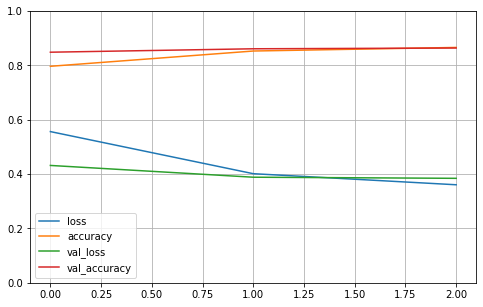

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [1]:
model.evaluate(x_test_scaler, y_test，verbose = 2)

SyntaxError: invalid character in identifier (<ipython-input-1-b92717caaf4e>, line 1)